# Análise e Transformação de Dados
#### Licenciatura em Engenharia Informática - Universidade de Coimbra
#### 2020/2021

## Projeto final

### Autores:
- João Filipe Guiomar Artur, 2019217853
- Samuel Santos Carinhas, 2019217199
- Sancho Amaral Simões, 2019217590

## 1. Introdução

<div style="text-align: justify">&nbsp;&nbsp;&nbsp;&nbsp;O presente projeto apresenta como finalidade a aplicação de alguns dos conhecimentos adquiridos pelos autores no âmbito da cadeira de <strong>Análise e Transformação de Dados</strong>, nomeadamente a análise de dados originalmente facultados no domínio temporal e a sua posterior transposição para o domínio da frequência / domínio misto (frequência/tempo), com recurso a ferramentas matemáticas como a transformada de Fourier e as suas variantes (DFT, STFT, ...). 
<br>&nbsp;&nbsp;&nbsp;&nbsp;Para o desenvolvimento deste projeto, foi fornecido um dataset no qual constam valores recolhidos por acelerómetros de smartphones nas três dimensões (x, y e z). Estes valores são provenientes de várias sequências de movimentos executados por um grupo de 30 voluntários. Nas referidas sequências encontram-se movimentos de tipo estático, dinâmico e de transição. A terminologia utilizada para caracterizar os grupos de movimentos é bastante autoxplicativa, como se vê em baixo. 
    
<ul>
     <li> 
         <h5> Dinâmicos </h5>
         <ol>
             <li> Andando (WALKING) </li>
             <li> Subindo Escadas (WALKING_UPSTAIRS) </li>
             <li> Descendo Escadas (WALKING_DOWNSTAIRS) </li>
         </ol>
     </li>
     <li> 
         <h5> Estáticos </h5>
         <ol>
             <li> Sentado (SITTING) </li>
             <li> De pé (STANDING) </li>
             <li> Deitado (LAYING) </li>
         </ol>
     </li>
    <li> 
         <h5> Transição </h5>
         <ol>
             <li> De pé -> Sentado (STAND_TO_SIT) </li>
             <li> Sentado -> De pé (SIT_TO_STAND) </li>
             <li> Sentado -> Deitado (SIT_TO_LIE) </li>
             <li> Deitado -> Sentado (LIE_TO_SIT) </li>
             <li> De pé -> Deitado (STAND_TO_LIE) </li>
             <li> Deitado -> De pé (LIE_TO_STAND) </li>
         </ol>
     </li>  
</ul>
    
&nbsp;&nbsp;&nbsp;&nbsp;
</div>

## 2. Workspace

&nbsp;&nbsp;&nbsp;&nbsp;Para maior legibilidade / facilidade de manutenção de código, foi criado um workspace inicial que contém algumas constantes utilizadas ao longo do desenvolvimento do projeto.

In [132]:
% region dependencies
addpath('functions/dft/');
addpath('functions/util/');
addpath('functions/plotters/');
% endregion dependencies

% region constants
X_AXIS = 1;
Y_AXIS = 2;
Z_AXIS = 3;
DATASETS_DIR = 'resources/txt/datasets';
LABELS_PATH = 'resources/txt/labels.txt';
COLORS = {'#2f4f4f', '#7f0000', '#008000', '#00008b', '#ff8c00', '#CC3322', '#11ff00', '#00ffff', '#ff00ff', '#1e90ff', '#ffe4b5', '#fd4002'};
ACTIVITIES = ["WALK", "WALK\_UP", "WALK\_DOWN", "SIT", "STAND", "LAY", "STAND\_SIT", "SIT\_STAND", "SIT\_LIE", "LIE\_SIT", "STAND\_LIE", "LIE\_STAND"];
ABS_SLOPE_PARAM = 'Absolute slope';
MAX_FREQ = 'Max frequency amplitude';
FS = 50;
THRESHOLD1 = 0.25;
THRESHOLD2 = 0.3;
WINDOW_SIZE = 6;
OVERLAP_SIZE = 3;
ACT_SIZES = [2000, 2500, 1500];
DYNAMIC_ACTIVITIES = [1, 2, 3];
LOW_PASS_MIN_FREQ = 0.2;
% end region constants

## 3. Importação de dados

&nbsp;&nbsp;&nbsp;&nbsp; Os datasets fornecidos foram importados através da utilização da função load_datasets. Esta percorre todos os ficheiros .txt no diretório especificado e lê, através da função dlmread, os valores lidos pelos acelerómetros, utilizando como delimitador o espaço.

In [133]:
%%file load_datasets.m

function datasets = load_datasets(directory)
    dataset_files = dir([directory '/*.txt']);
    len = length(dataset_files);
    datasets = cell(1, len);
    
    for i = 1:len
        datasets(i) = {dlmread([directory '/' dataset_files(i).name], ' ')};
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\load_datasets.m'.


In [134]:
labels = dlmread(LABELS_PATH, ' ');
datasets = load_datasets(DATASETS_DIR);

## 4. Representação dos sinais

In [136]:
%%file plot_datasets.m

%{
@def plot_datasets
@brief Function that plots the dataset describing the experiences.

@param datasets
Datasets to containing the values obtained in the experiences.

@param fs
Sample frequency used when capturing the values on the dataset.

@param labels
Vector with labels describing the experiences performed by the users.

@param activities
Vector with names atributed to each activity.

@param act_colors
Vector with color RGB codes to assign to mark each activity.
%}
function plot_datasets(datasets, fs, labels, activities, act_colors)
    len = length(datasets);
    ts = 1/fs;
   
    % consider all of the activities present in the datasets
    for i = 1:len
        figure;
        dataset = cell2mat(datasets(i));

        indexes = find(labels(:,1) == i);
       
        exp = i;
        
        % consider each of the three dimensions for each activity
        for k = 1:3
            y_lbl = sprintf('ACC angle - %s (m/s^2)', get_axis_name(k));
            
            subplot(3, 1, k);
            plot(ts/60:ts/60:(length(dataset) * ts)/60, dataset(:, k), 'k');
            ylabel(y_lbl);
            xlabel('Time (min)')
           
            hold on

            for j=1:length(indexes)
                index = indexes(j);
                user = labels(index, 2);
                act = labels(index, 3);
                start = labels(index, 4);
                finish = labels(index, 5);
                
                x = start * ts/60:ts/60:finish * ts/60;
                y_point = mean(dataset(start:finish, k)) + 0.7 * (-1)^index;
                color_hex = char(act_colors(act));
                color = sscanf(color_hex(2:end),'%2x%2x%2x',[1 3])/255;
                
                plot(x, dataset(start:finish, k), 'Color', color);
                text(start*ts/60, y_point, activities(act),'Fontsize', 7);
                plt_title = sprintf('Experience %d, User %d', exp, user);
                sgtitle(plt_title);
            end

            hold off;
        end
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_datasets.m'.


![Title](resources/plots/datasets/dataset1.png)
![Title](resources/plots/datasets/dataset2.png)
![Title](resources/plots/datasets/dataset3.png)
![Title](resources/plots/datasets/dataset4.png)
![Title](resources/plots/datasets/dataset5.png)
![Title](resources/plots/datasets/dataset6.png)
![Title](resources/plots/datasets/dataset7.png)
![Title](resources/plots/datasets/dataset8.png)


## 5. Preparação dos datasets

In [121]:
%%file prepare_datasets.m

function [num_act_ocurrences, acts_means, dft_freqs, dft_means] = prepare_datasets(datasets, dim, fs, unif_sizes, labels, activities)
   num_act = length(activities);
   dft_means = cell(1, num_act);
   dft_freqs = cell(1, num_act);
   acts_means = cell(1, num_act);
   num_act_ocurrences = zeros(1, num_act);
   min_act_size = zeros(1, num_act);
   dyn_act_size = unif_sizes(1);
   static_act_size = unif_sizes(2);
   transition_act_size = unif_sizes(3);
    
   len = length(datasets);
   
   for i = 1:len
       dataset = cell2mat(datasets(i));
       
       indexes = find(labels(:, 1) == i);
           
       for j=1:length(indexes)
           index = indexes(j);
           act = labels(index, 3);
           start = labels(index, 4);
           finish = labels(index, 5);

           act_frag = dataset(start:finish, dim);

           num_act_ocurrences(act) = num_act_ocurrences(act) + 1;
           l = size(act_frag, 1);
           
           if l < min_act_size(act) || min_act_size(act) == 0 
               min_act_size(act) = l;
           end

           if act < 4
               act_padded = [act_frag ; zeros(dyn_act_size - l, 1)];
           elseif act < 6
               act_padded = [act_frag ; zeros(static_act_size - l, 1)];    
           else
               act_padded = [act_frag ; zeros(transition_act_size - l, 1)];
           end          

           [f, m_x] = calc_dft(act_padded, fs, start - finish);

           if num_act_ocurrences(act) == 1
               acts_means(act) = {act_padded};
               dft_freqs(act) = {f(1:end - 1)};
               dft_means(act) = {m_x};
           else
               acts_means(act) = {cell2mat(acts_means(act)) + act_padded};
               dft_means(act) = {cell2mat(dft_means(act)) + m_x};   
           end
       end
  
   end
   
   for i = 1:length(activities)
       dft_means(i) = {cell2mat(dft_means(i)) / num_act_ocurrences(i)};
       values = cell2mat(acts_means(i));
       acts_means(i) = {values / num_act_ocurrences(i)};
       acts_means(i) = {values(1:min_act_size(i))};
   end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\prepare_datasets.m'.


In [122]:
[num_act_ocurrences, meaned_acts_x, freqs_x, dfts_x] = prepare_datasets(datasets, X_AXIS, FS, ACT_SIZES, labels, ACTIVITIES);
[~, meaned_acts_y, freqs_y, dfts_y] = prepare_datasets(datasets, Y_AXIS, FS, ACT_SIZES, labels, ACTIVITIES);
[~, meaned_acts_z, freqs_z, dfts_z] = prepare_datasets(datasets, Z_AXIS, FS, ACT_SIZES, labels, ACTIVITIES);

## 6. Segmentos associados às atividades

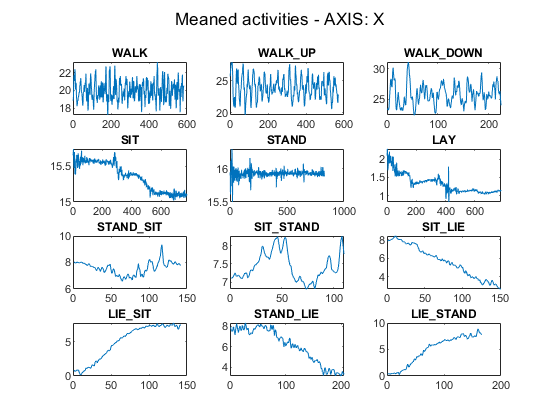

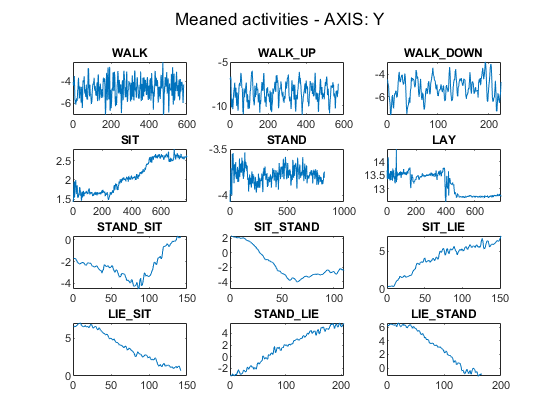

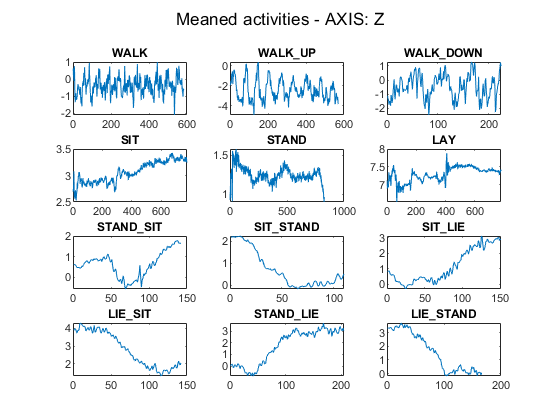

In [123]:
plot_meaned_activities(meaned_acts_x, X_AXIS, ACTIVITIES);
plot_meaned_activities(meaned_acts_y, Y_AXIS, ACTIVITIES);
plot_meaned_activities(meaned_acts_z, Z_AXIS, ACTIVITIES);

## 7. Seleção da janela deslizante

In [124]:
%%file plot_window.m

function plot_window(win_func, win_size, win_name)
    win = win_func(win_size);
    
    figure;
    
    plot(1:win_size, win);
    title(win_name);
    xlabel('N')
    ylabel('W(N)');
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_window.m'.


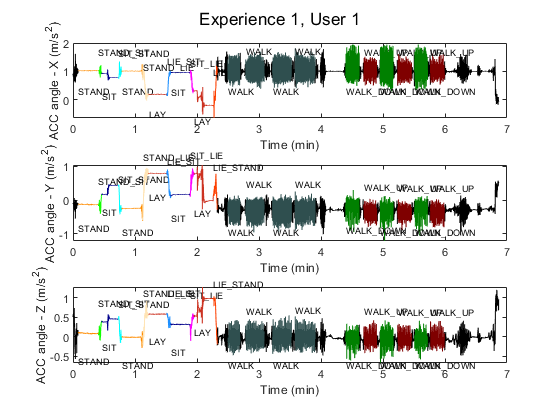

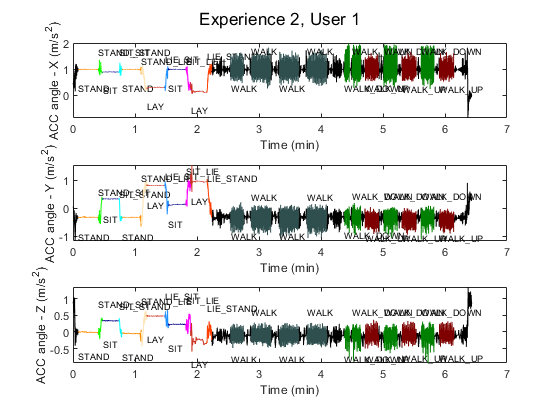

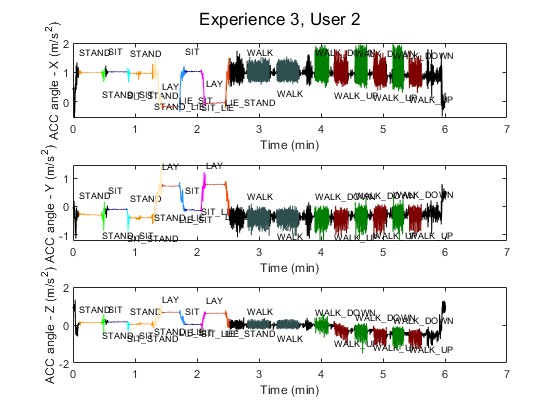

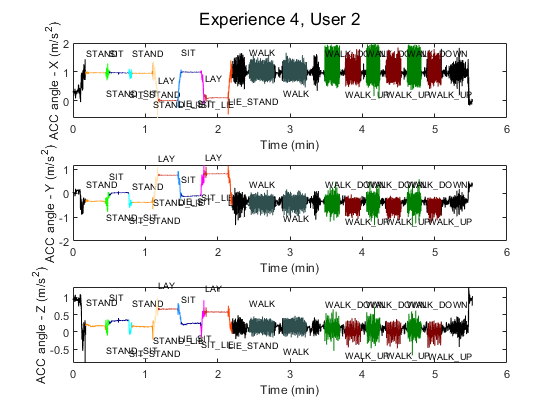

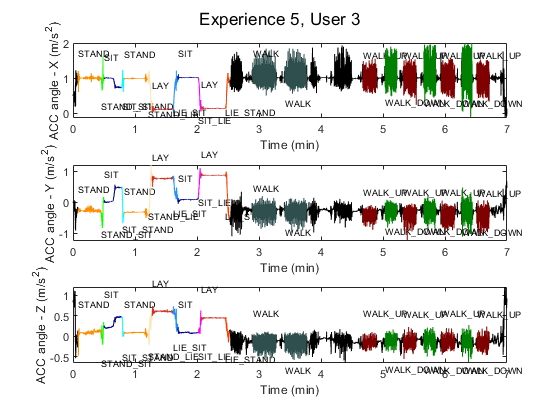

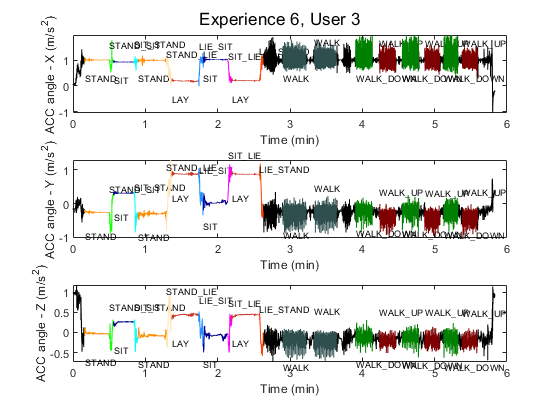

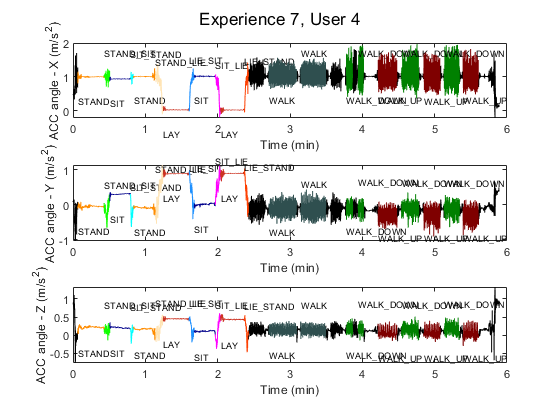

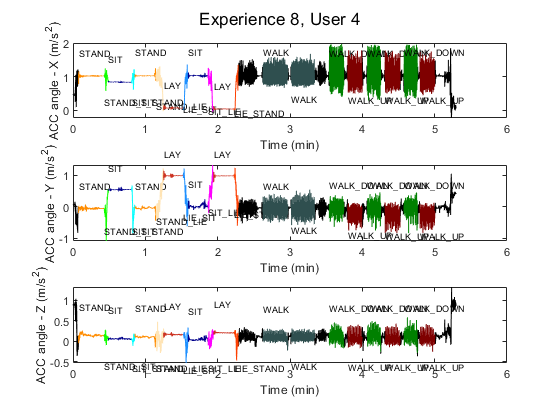

In [125]:
plot_datasets(datasets, FS, labels, ACTIVITIES, COLORS);

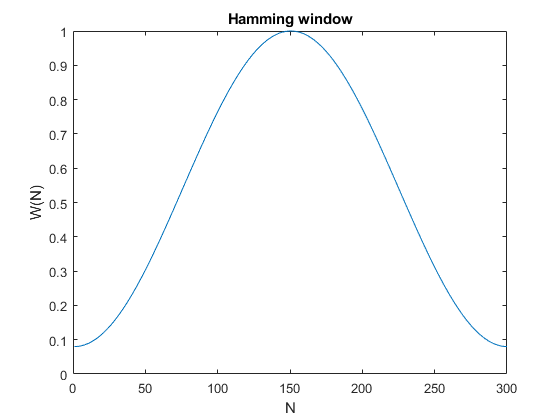

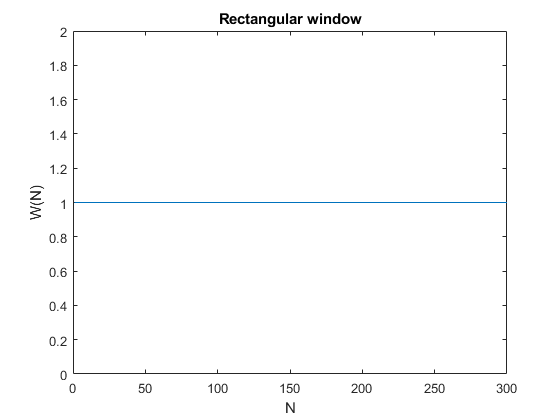

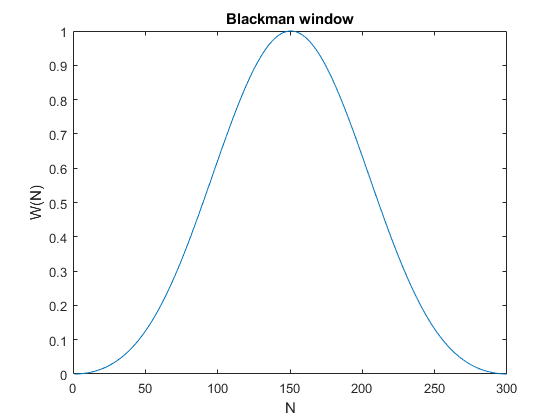

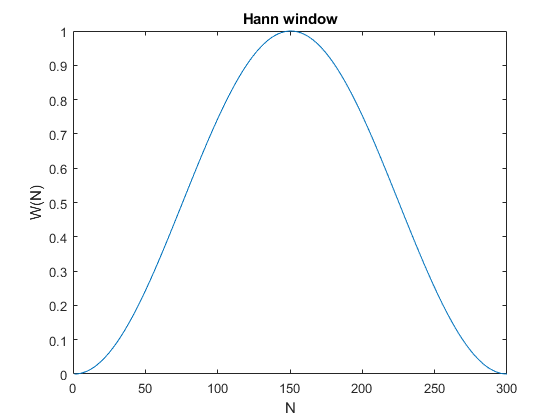

In [126]:
plot_window(@hamming, WINDOW_SIZE * FS, 'Hamming window');
plot_window(@rectwin, WINDOW_SIZE * FS, 'Rectangular window');
plot_window(@blackman, WINDOW_SIZE * FS, 'Blackman window');
plot_window(@hann, WINDOW_SIZE * FS, 'Hann window');

![Title](resources/plots/windowed_dft.png)

## 8. DFT dos sinais associados às atividades

In [127]:
%%file plot_meaned_dfts.m

function plot_meaned_dfts(freqs, meaned_dfts, num_ocurrences, activities, axis)
    for i = 1:length(activities)
        plot(cell2mat(freqs(i)), cell2mat(meaned_dfts(i)));
        plt_title = sprintf('DFT mean for activity %s (%d instances in all datasets) - AXIS %s', activities(i), num_ocurrences(i), get_axis_name(axis));
        title(plt_title);
        xlabel('Frequency (Hz)');
        ylabel('Magnitude');
        pause(1);
    end
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\plot_meaned_dfts.m'.


![Title](resources/plots/dfts/dft_x.png)
![Title](resources/plots/dfts/dft_y.png)
![Title](resources/plots/dfts/dft_z.png)

## 9. Estiva do número de passos por minuto por utilizador

In [128]:
%%file calc_steps_per_min.m

function steps_per_min = calc_steps_per_min(data, freq, fs, thres_ref)
    
    % obtain the number of data entries and the number of components
    % considered
    N = size(data, 1);
    num_of_dim = size(data, 2);
    
    % prepare matrices for the gravitational acceleration and for the user
    % acceleration
    grav_ac = zeros(num_of_dim, N);
    user_ac = zeros(num_of_dim, N);
    
    % calculate user acceleration by removing gravitational acceleration
    % from total acceleration measured by the accelerometer on all of the
    % dimensions
    for i=1:num_of_dim
        grav_ac(i,:) = lowpass(data(:, i), freq, fs);
        user_ac(i, :) = data(:, i)'- grav_ac(i, :);
    end
    % calculate vertical acceleration
    vert_ac = dot(grav_ac, user_ac);
    
    [freqs, dft] = calc_dft(vert_ac, fs, 1, N);
    
    % remove non-positive values to discard duplicate values
    dft = dft(freqs > 0);
    freqs = freqs(freqs > 0);
    
    % define a threshold to discard lower step values and consider the first
    % relevant value to be the number of steps per minute
    threshold = max(dft) * thres_ref;
    [~, peaks_indexes] = findpeaks(dft, 'MinPeakHeight', threshold);
    peak_index = peaks_indexes(1);
    steps_per_min = freqs(peak_index) * 60;    
end
    

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\calc_steps_per_min.m'.


In [129]:
%%file calc_act_steps_per_min.m

function [mean_value, std_value] = calc_act_steps_per_min(data, freq, fs, thres_ref)
    N = length(data);
    
    values = [];
    for i=1:N
        data_x = data{i}(:, 1);
        data_y = data{i}(:, 2);
        data_z = data{i}(:, 3);
        values = [values, calc_steps_per_min([data_x, data_y, data_z], freq, fs, thres_ref)];
    end
    mean_value = mean(values);
    std_value = std(values);
    
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\calc_act_steps_per_min.m'.


In [130]:
%%file calc_users_steps_per_min

function steps_table = calc_users_steps_per_min(datasets, fs, min_freq, thres_ref, num_users, dynamic_acts, labels) 
    
    users = 1:1:num_users;
    
    % create arrays to store the data;
    walk_avgs = [];
    walk_stds = [];
    walk_up_avgs = [];
    walk_up_stds = [];
    walk_down_avgs = [];
    walk_down_stds = [];
    
    for i=1:num_users
        user_acts = group_activities(datasets, i, labels, dynamic_acts);
        
        %calculate the average steps per minute and standard deviation for
        %the WALK activity
        walk_data = user_acts{1};
        [mean_value, std_value] = calc_act_steps_per_min(walk_data, min_freq, fs, thres_ref);
        
        walk_avgs = [walk_avgs, mean_value];
        walk_stds = [walk_stds, std_value];
        
        %calculate the average steps per minute and standard deviation for
        %the WALK_UP activity
        walk_up_data = user_acts{2};
        [mean_value, std_value] = calc_act_steps_per_min(walk_up_data, min_freq, fs, thres_ref);
        
        walk_up_avgs = [walk_up_avgs, mean_value];
        walk_up_stds = [walk_up_stds, std_value];
        
        %calculate the average steps per minute and standard deviation for
        %the WALK_DOWN activity
        walk_down_data = user_acts{3};
        [mean_value, std_value] = calc_act_steps_per_min(walk_down_data, min_freq, fs, thres_ref);
        
        walk_down_avgs = [walk_down_avgs, mean_value];
        walk_down_stds= [walk_down_stds, std_value];
        
    end
    
    USER = users';
    WALK_MEAN = walk_avgs';
    WALK_STD = walk_stds';
    WALK_UP_MEAN = walk_up_avgs';
    WALK_UP_STD = walk_up_stds';
    WALK_DOWN_MEAN = walk_down_avgs';
    WALK_DOWN_STD = walk_down_stds';
    
    steps_table = table(USER, WALK_MEAN, WALK_STD, WALK_UP_MEAN, WALK_UP_STD, WALK_DOWN_MEAN, WALK_DOWN_STD);
end

Created file 'C:\Users\smart\Documents\GitRepos\Actionalizer\calc_users_steps_per_min'.


In [131]:
disp(calc_users_steps_per_min(datasets, FS, LOW_PASS_MIN_FREQ, THRESHOLD2, 4, DYNAMIC_ACTIVITIES, labels));


  File C:\Users\smart\Documents\GitRepos\Actionalizer\functions\dft\calc_act_steps_per_min.m, line 29, in calc_act_steps_per_min

  File C:\Users\smart\Documents\GitRepos\Actionalizer\functions\dft\calc_users_steps_per_min.m, line 48, in calc_users_steps_per_min
Unrecognized function or variable 'freq'.



Error: -1

## 10. Distinção das famílias e tipos de atividades

In [ ]:
%%file plot_dataset_param.m

function plot_dataset_param(meaned_acts, act_names, param_func, param_name, axis, colors, dx, dy)  
    figure;
    
    hold on;
    
    for i = 1:length(meaned_acts)
         values = cell2mat(meaned_acts(i));
         domain = 1:length(values);
         
         param_value = param_func(domain, values);
         scatter(i, param_value, 'MarkerFaceColor', colors{i}, 'MarkerEdgeColor', 'black');
         point_lbl = sprintf('%.5f', param_value);
         ylbl = sprintf('Comparison param (%s)', param_name);
         text(i + dx, param_value + dy * (-1)^i, point_lbl, 'Fontsize', 8);
         xlabel('Activity index');
         ylabel(ylbl);
    end
    
    legend(act_names(:), 'Location', 'northwest');
    plt_title = sprintf('%s param comparison - AXIS: %s', param_name, get_axis_name(axis));
    title(plt_title);
    
    hold off;
end

In [ ]:
plot_dataset_param(meaned_acts_x, ACTIVITIES, @get_abs_slope, ABS_SLOPE_PARAM, X_AXIS, COLORS, 0.0025, 0.0015);
plot_dataset_param(meaned_acts_y, ACTIVITIES, @get_abs_slope, ABS_SLOPE_PARAM, Y_AXIS, COLORS, 0.0025, 0.0015);
plot_dataset_param(meaned_acts_z, ACTIVITIES, @get_abs_slope, ABS_SLOPE_PARAM, Z_AXIS,COLORS, 0.0025, 0.0015);
plot_dataset_param(meaned_acts_x, ACTIVITIES, @get_max_amplitude, MAX_FREQ, X_AXIS, COLORS, 0.003, 0.03);
plot_dataset_param(meaned_acts_y, ACTIVITIES, @get_max_amplitude, MAX_FREQ, Y_AXIS, COLORS, 0.003, 0.03);
plot_dataset_param(meaned_acts_z, ACTIVITIES, @get_max_amplitude, MAX_FREQ, Z_AXIS, COLORS, 0.003, 0.03);

![Title](resources/plots/param_comparisons/abs_slope_x.png)
![Title](resources/plots/param_comparisons/abs_slope_y.png)
![Title](resources/plots/param_comparisons/abs_slope_z.png)

![Title](resources/plots/param_comparisons/max_freq_amp_x.png)
![Title](resources/plots/param_comparisons/max_freq_amp_y.png)
![Title](resources/plots/param_comparisons/max_freq_amp_z.png)

![Title](resources/plots/relev_freqs/relev_freqs_x.png)
![Title](resources/plots/relev_freqs/relev_freqs_y.png)
![Title](resources/plots/relev_freqs/relev_freqs_z.png)

## 11. Aplicação da STFT aos datasets

In [ ]:
%%file calc_stft.m

%{
@def calc_stft
@brief Function that calculates the STFT for a given dataset.

@param dataset
Dataset to use on STFT calculation.

@param fs
Sample frequency used when capturing the values on the dataset.

@param window_type
The type of window to apply to the dataset.

@param window_size
The size of each window to consider.

@param overlap_size
The size of overlaping to consider on the window application to the
dataset.

@return relev_freqs - vector with the relevant frequencies obtained.
        relev_mags -  vector with the magnitudes associated to each frequency obtained.
        times - vector with the time instances associated to each frequency
        obtained.
%}
function [relev_freqs, relev_mags, times] = calc_stft(x, fs, window_type, window_size, overlap_size)
    N = length(x);
    ts = 1/fs;
    
    % calculate the number of window frames and the number of overlapings
    n_frame = round(window_size * fs);
    n_overlap = round(overlap_size * fs);
    
    % obtain the frequencies vector
    if mod(n_frame, 2) == 0
        f_frame = -fs/2:fs/n_frame:fs/2-fs/n_frame;
    else
        f_frame = -fs/2 + fs/(2*n_frame):fs/n_frame:fs/2-fs/(2*n_frame);
    end
    
    % calculate the window
    window = window_type(n_frame);
    
    % prepare arrays to store the results
    relev_freqs = [];
    relev_mags = [];
    times = [];
    
    % obtain the time vector
    t = 0:ts:(N-1)*ts;
    
    for i = 1:n_frame-n_overlap:N-n_frame+1
        % obtain the frame to consider
        x_frame = x(i:i+n_frame-1);
        x_frame = dtrend(x_frame);
        
        % apply the window to the frame
        x_frame = x_frame.*window;
        
        % calculate the DFT of the frame
        X_frame = fftshift(fft(x_frame));
        
        % obtain the magnitudes
        m_X_frame = abs(X_frame);
        
        % obtain the maximum magnitude
        mag = max(m_X_frame);
        
        % obtain the relevant frequencies and the corresponding magnitutes
        % and time instances
        freqs = f_frame(abs(m_X_frame - mag) < 0.001);
        relev_freqs = [relev_freqs, abs(freqs(1))];
        relev_mags = [relev_mags, mag];
        times = [times, t(i)];
    end
        
end

In [ ]:
%%file plot_stft.m

%{
@def plot_stft
@brief Function that calculates the STFTs from the datasets and plots the results.

@param dataset
Dataset to use on STFT calculation.

@param fs
Sample frequency used when capturing the values on the dataset.

@param window_type
The type of window to apply to the dataset.

@param window_size
The size of each window to consider.

@param overlap_size
The size of overlaping to consider on the window application to the
dataset.
%}
function plot_stft(dataset, fs, window_type, window_size, overlap_size)
    figure;   
    % plot the stft for in all of the three dimensions (x, y, z)
    for k = 1:3
        [relev_freqs, ~, times] = calc_stft(dataset(:,k), fs, window_type, window_size, overlap_size);
        subplot(3,1,k)
        plot(times/60, relev_freqs, 'o');
        plt_title = sprintf('AXIS %s', get_axis_name(k));
        title(plt_title);
    end
    
    % plot the spectrogram for the stft for in all of the three dimensions (x, y, z)
    for k = 1:3
        figure;
        xlabel('Time (s)');
        spectrogram(dataset(:,k), window_size*fs, overlap_size*fs, 'yaxis');
        plt_title = sprintf('AXIS: %s', get_axis_name(k));
        title(plt_title);
    end
end

In [ ]:
plot_stft(cell2mat(datasets(1)), FS, @hamming, WINDOW_SIZE, OVERLAP_SIZE);